In [662]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [663]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [664]:
df=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/data.csv")
df.head()

,Unnamed: 0,date,dish_id_1
0,0,2019-01-01,120
1,1,2019-01-02,316
2,2,2019-01-03,302
3,3,2019-01-04,334
4,4,2019-01-05,189


In [665]:
#dropping column of no use and changing the index
df.drop(["Unnamed: 0"],inplace=True,axis=1)
df["date"]=pd.to_datetime(df["date"])
df.head()

,date,dish_id_1
0,2019-01-01,120
1,2019-01-02,316
2,2019-01-03,302
3,2019-01-04,334
4,2019-01-05,189


In [666]:
#checking null values
df.isnull().sum()

date         0
dish_id_1    0
dtype: int64

In [667]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dish_id_1,209.0,155.200957,97.312037,0.0,85.0,126.0,210.0,403.0


#**visualizing the data**

Text(0.5, 0, 'date')

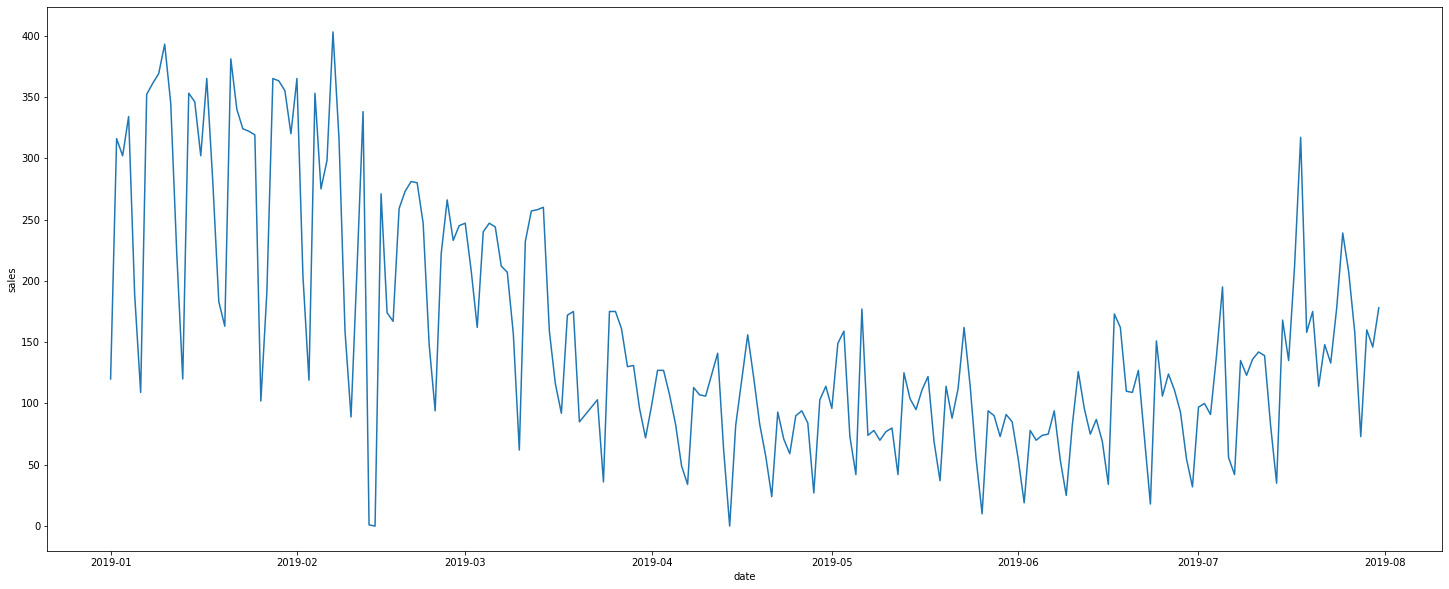

In [668]:

plt.figure(figsize=(25,10))
plt.plot(df["date"],df["dish_id_1"])
plt.ylabel("sales")
plt.xlabel("date")

## **Data is less**

In [669]:
df["day"]=df["date"].dt.day
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [670]:
df.head()

,date,dish_id_1,day,year,month
0,2019-01-01,120,1,2019,1
1,2019-01-02,316,2,2019,1
2,2019-01-03,302,3,2019,1
3,2019-01-04,334,4,2019,1
4,2019-01-05,189,5,2019,1


## **Linear Regression model for prediction**

In [671]:
from sklearn import linear_model
from sklearn import metrics

#preparing data for fitting
train_input=df[["day","month","year"]]
train_output=df["dish_id_1"]

#Prediction data
lst=["2019-08-01","2019-08-02","2019-08-03","2019-08-04","2019-08-05","2019-08-06","2019-08-07"]
df_pre=pd.DataFrame()
df_pre["date"]=pd.to_datetime(lst)
df_pre["day"]=df_pre["date"].dt.day
df_pre['year'] = df_pre['date'].dt.year
df_pre['month'] = df_pre['date'].dt.month
#model instance
reg=linear_model.LinearRegression()
reg.fit(train_input,train_output)
df_pre["Predicted Sales"]=reg.predict(df_pre[['day','month','year']])
df_pre.drop(["day","year","month"],axis=1,inplace=True)
display(df_pre)

,date,Predicted Sales
0,2019-08-01,48.193702
1,2019-08-02,47.883929
2,2019-08-03,47.574156
3,2019-08-04,47.264383
4,2019-08-05,46.954610
5,2019-08-06,46.644838
6,2019-08-07,46.335065


**The linear regression model is not working well as the data is of seasonal time so need to use sarimax.**

## **Using SArimax model for predicting**

Need to find

1. p: ar model lags
2. d: differencing
3. p: MA lags

reference blog: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [673]:
df=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/data.csv")
df.head()

,Unnamed: 0,date,dish_id_1
0,0,2019-01-01,120
1,1,2019-01-02,316
2,2,2019-01-03,302
3,3,2019-01-04,334
4,4,2019-01-05,189


In [674]:
#dropping column of no use and changing the index
df.drop(["Unnamed: 0"],inplace=True,axis=1)
df["date"]=pd.to_datetime(df["date"])
df.head()

,date,dish_id_1
0,2019-01-01,120
1,2019-01-02,316
2,2019-01-03,302
3,2019-01-04,334
4,2019-01-05,189


In [675]:
df.set_index("date",inplace=True)

In [676]:
#checking and filling missing date
import pandas as pd

idx = pd.date_range('2019-01-01', '2019-08-07')

df=df.reindex(idx, fill_value=round(df["dish_id_1"].mean()))


In [677]:
df.tail()

,dish_id_1
2019-08-03,155
2019-08-04,155
2019-08-05,155
2019-08-06,155
2019-08-07,155


# **Stationary**

In [678]:
from statsmodels.tsa.stattools import adfuller
#H0: Null hypothesis= It is stationary
#H1: Alternate hypothesis= It is not stationary

def adfuller_text(sales):
  result=adfuller(sales)
  labels=['ADF TEST Statistic','p-value','Lags used','Number of observation used']
  for value,label in zip(result,labels):
    print(f"{label}:{value}")
  if result[1]>=0.05:
    print("Strong evidence against null hypothesis, reject null hypothesis")
  else:
    print("weak evidence against  hypothesis, accept null hypothesis")
  return 0

In [679]:
adfuller_text(df["dish_id_1"])

ADF TEST Statistic:-2.150797797481652
p-value:0.22458483864127465
Lags used:14
Number of observation used:204
Strong evidence against null hypothesis, reject null hypothesis


0

# **Differencing**

In [680]:
df["sales week difference"]=df["dish_id_1"]-df["dish_id_1"].shift(7)
df.head()

,dish_id_1,sales week difference
2019-01-01,120,NaN
2019-01-02,316,NaN
2019-01-03,302,NaN
2019-01-04,334,NaN
2019-01-05,189,NaN


In [681]:
adfuller_text(df["sales week difference"].dropna())

ADF TEST Statistic:-3.9202727824483197
p-value:0.0018906141162525977
Lags used:14
Number of observation used:197
weak evidence against  hypothesis, accept null hypothesis


0

Text(0.5, 0, 'date')

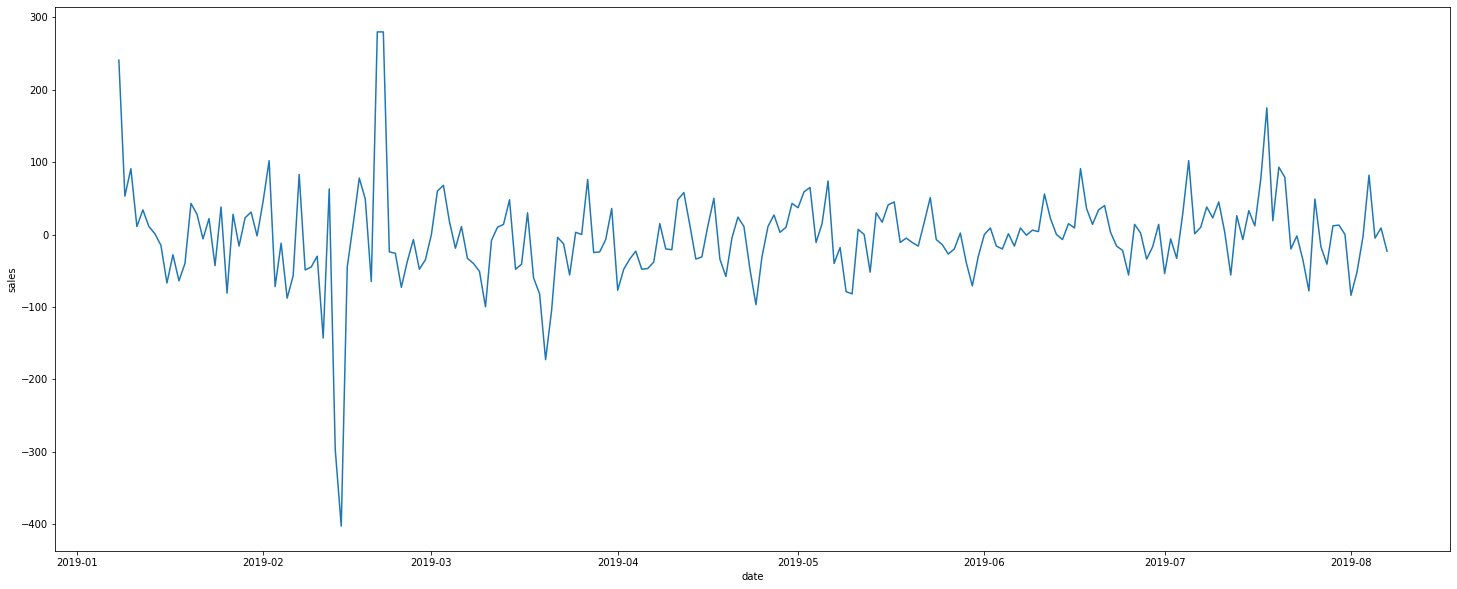

In [682]:
plt.figure(figsize=(25,10))
plt.plot(df["sales week difference"])
plt.ylabel("sales")
plt.xlabel("date")

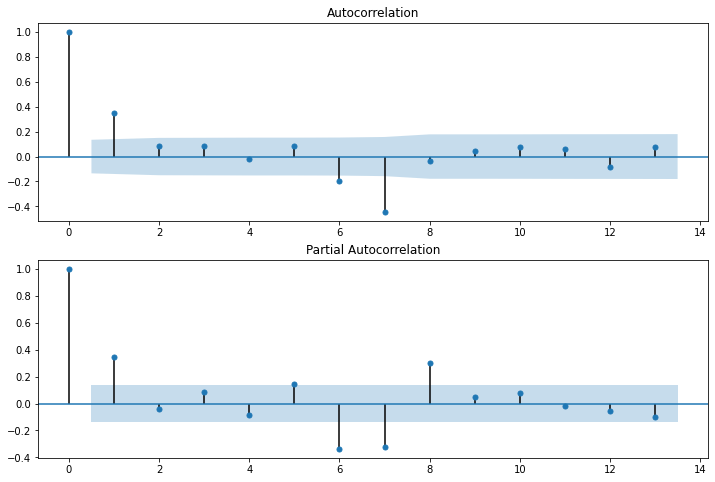

In [683]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=statsmodels.graphics.tsaplots.plot_acf(df['sales week difference'].dropna(),lags=13,ax=ax1)
ax2=fig.add_subplot(212)
fig=statsmodels.graphics.tsaplots.plot_pacf(df['sales week difference'].dropna(),lags=13,ax=ax2)

p=1 from graph pacf

q=0,1 from acf

d=1

In [684]:
df.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-07-29', '2019-07-30', '2019-07-31', '2019-08-01',
               '2019-08-02', '2019-08-03', '2019-08-04', '2019-08-05',
               '2019-08-06', '2019-08-07'],
              dtype='datetime64[ns]', length=219, freq='D')

In [685]:
df.drop("sales week difference",inplace=True,axis=1)
print(df.shape)

(219, 1)


In [686]:
df.isna().sum()

dish_id_1    0
dtype: int64

In [687]:
import statsmodels.api as sm 
model=sm.tsa.statespace.SARIMAX(df["dish_id_1"],
                                order=(1,1,1),
                                seasonal_order=(1,1,1,7)) 
result=model.fit(disp=False)

# **Testing the model**

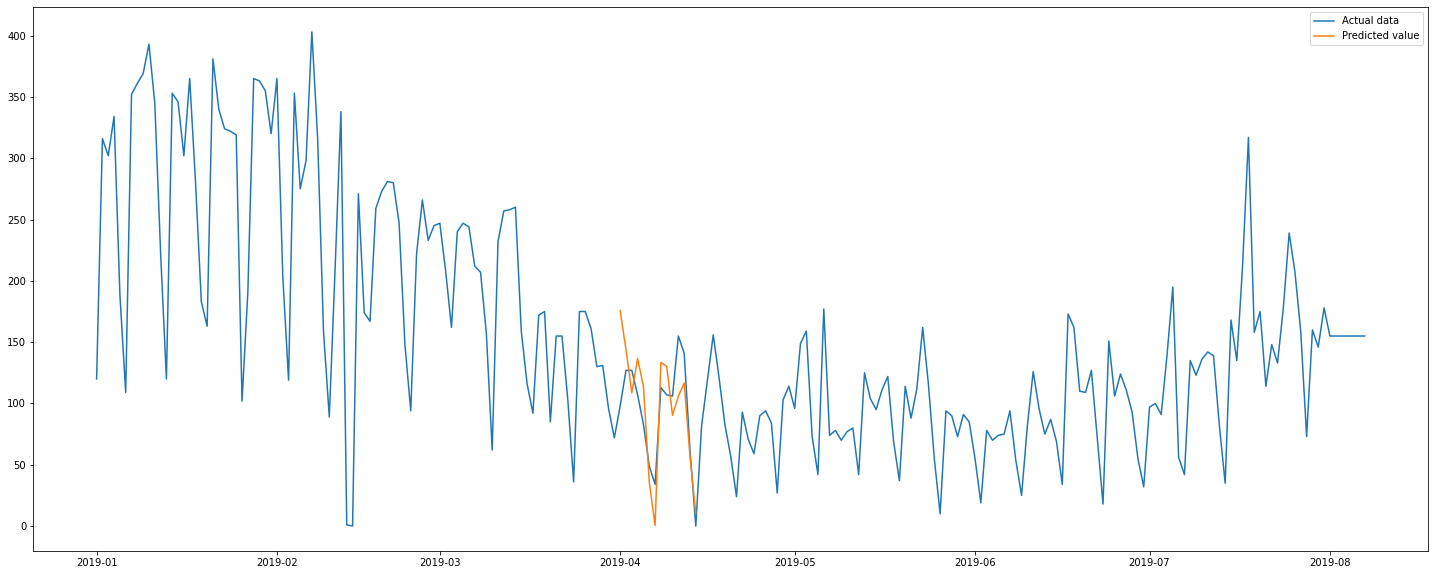

In [688]:
plt.figure(figsize=(25,10))
df["forcast"]=result.predict(start=90,end=103)
plt.plot(df["dish_id_1"],label="Actual data")
plt.plot(df["forcast"],label="Predicted value")
plt.legend()

In [689]:
df.drop(['forcast'],inplace=True,axis=1)

In [690]:
df.columns

Index(['dish_id_1'], dtype='object')

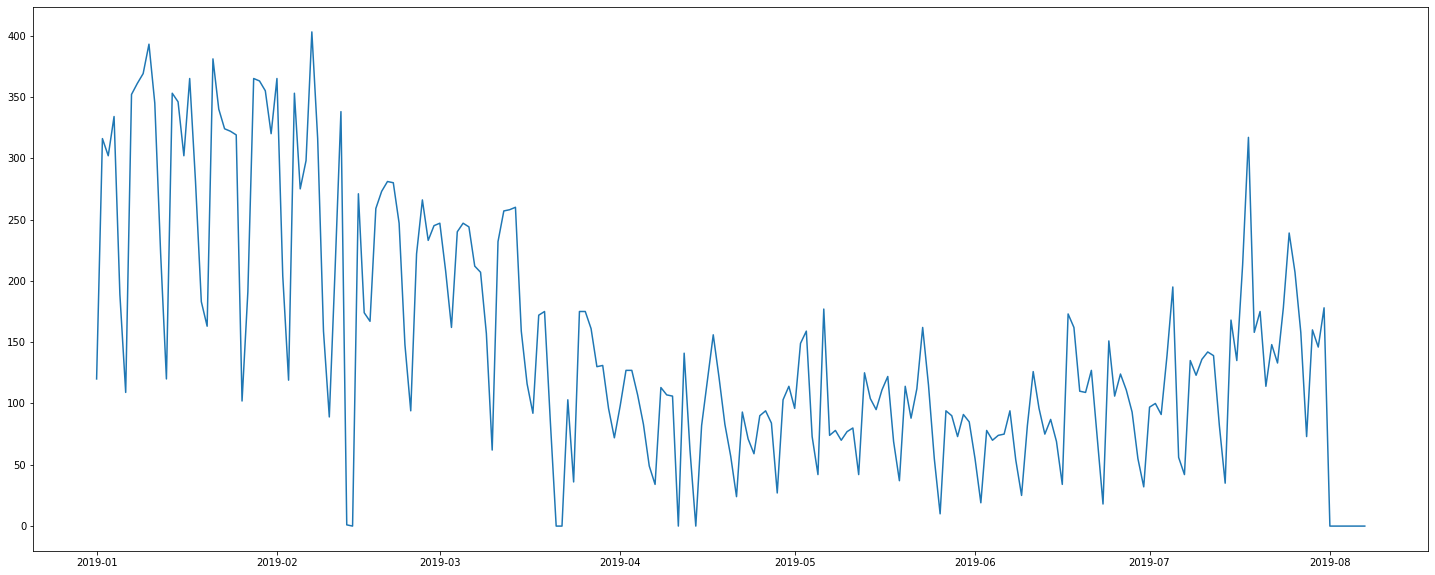

In [691]:
plt.figure(figsize=(25,10))
plt.plot(future_df[["dish_id_1"]])

In [692]:
pred=result.predict(open=len(df['dish_id_1'])-8,close=len(df['dish_id_1'])-1)
prediction=pd.DataFrame(pred,columns=["sales"])
prediction["sales"]=prediction["sales"].apply(lambda x: round(x))

# **Prediction for next 7 days**

In [693]:
prediction.tail(7)

,sales
2019-08-01,221
2019-08-02,163
2019-08-03,128
2019-08-04,99
2019-08-05,206
2019-08-06,157
2019-08-07,186
